## import package

In [ ]:
from IPython.display import display
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT

In [57]:
import numpy as np
import scipy.sparse
import math
import datetime
import time
import itertools
import pandas as pd
%matplotlib inline

## load data

In [58]:
# train set, validation set 불러오기
train = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/train_sample.csv')
valid = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/validation_sample.csv')
# 버킷에서 csv 불러오기 -> df = spark.read.format("csv").option("header", "true").load("csvfile.csv")

In [37]:
# print((train.count(), len(train.columns)))
# print((valid.count(), len(valid.columns)))

(102091, 31)
(25656, 31)


In [59]:
# train set, validation set 합치기
union = train.union(valid)

In [8]:
# print((union.count(), len(union.columns)))

(127747, 31)


In [60]:
train_raw_df = union
train_raw_df.printSchema()
# print((train_raw_df.count(), len(train_raw_df.columns)))

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- label: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- is_train: string (nullable = true)
 |-- country: string (nullable = true)
 |-- day_event: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- timestamp_event: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc

In [6]:
pd.DataFrame(train_raw_df.take(5), columns=train_raw_df.columns).transpose()

,0,1,2,3,4
display_id,11269,17083,3720,14821,1775
ad_id,3190,36415,36625,36415,35998
label,0,1,0,0,0
is_leak,-1,-1,-1,-1,0
weekend,0,0,0,0,0
view_publisher_id,180,450,40,3,221
view_source_id,U,7736,1248,3841,844
hour,6,4,5,5,6
platform,2,1,1,1,1
traffic_source,1,1,2,2,1


In [61]:
# 'weekend', 'day_event', 'timestamp_event' 제외 ('weekend'는 레벨이 하나라서, 시간 변수는 필요 없어서) 
train_raw_df = train_raw_df.select([c for c in train_raw_df.columns if c not in {'weekend', 'day_event', 'timestamp_event'}])
train_raw_df = train_raw_df.withColumnRenamed("label", "ClickOrNot")
train_raw_df.printSchema()
print((train_raw_df.count(), len(train_raw_df.columns))) # (127747, 28)
# 원하는 컬럼 제외하고 셀렉하는 방법 -> df.select([c for c in df.columns if c not in {'column_1', 'column_2', 'column_3'}])

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- is_train: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_publisher_id: string (nullable = true)
 |-- pop_advertiser_id: string (nullable 

## feature engineering - numeric

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numeric_features = [t[0] for t in df.dtypes if t[1] == 'int'] # numeric features 이름 저장
# df.select(numeric_features).describe().toPandas().transpose()

## feature engineering - categorical

In [62]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['view_publisher_id', 'view_source_id', 'hour', 'platform', 'traffic_source', 'country', 'campaign_id', 'advertiser_id', 'ad_category_id', 'ad_topic_id', 'view_category_id', 'view_topic_id', 'ad_source_id', 'ad_publisher_id', 'pop_ad_id', 'pop_ad_doc_id', 'pop_ad_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_view_doc_ad_doc', 'pop_ad_source_id', 'pop_ad_topic_id', 'pop_ad_category_id']
# categoricalColumns : 23개
# 31 - 23 = 8 ('display_id', 'ad_id', 'ClickOrNot', 'is_leak', 'is_train', 'weekend', 'day_event', 'timestamp_event')
stages = []

In [63]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

## feature engineering - label

In [64]:
label_stringIdx = StringIndexer(inputCol = 'ClickOrNot', outputCol = 'label')
stages += [label_stringIdx]

## feature engineering - assembler (categorical)

In [65]:
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## feature engineering - assembler (numeric)

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numericCols = []
# assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stages += [assembler]

## pipeline

In [66]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_raw_df)
train_transform_df = pipelineModel.transform(train_raw_df)
cols = train_raw_df.columns
selectedCols = ['label', 'features'] + cols
train_selected_df = train_transform_df.select(selectedCols)

In [16]:
train_selected_df.printSchema()
print((train_selected_df.count(), len(train_selected_df.columns))) # 28 -> 30 : new columns('label', 'features') are added

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- is_train: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pu

In [17]:
pd.DataFrame(train_selected_df.take(5), columns=train_selected_df.columns).transpose()

,0,1,2,3,4
label,0,1,0,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
display_id,11269,17083,3720,14821,1775
ad_id,3190,36415,36625,36415,35998
ClickOrNot,0,1,0,0,0
is_leak,-1,-1,-1,-1,0
view_publisher_id,180,450,40,3,221
view_source_id,U,7736,1248,3841,844
hour,6,4,5,5,6
platform,2,1,1,1,1


In [122]:
# print(type(train_selected_df))

pyspark.sql.dataframe.DataFrame

## train, valid split

In [67]:
train = train_selected_df.filter(train_selected_df.is_train==1)
valid = train_selected_df.filter(train_selected_df.is_train==0)

In [20]:
# print("Training Dataset Count: " + str(train.count()))
# print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 102608
Validation Dataset Count: 25139


## logistic regression model

### logistic regression - training

In [68]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10) # x는 'features', y는 'label'
lrModel = lr.fit(train) # 로지스틱 회귀 모델 트레이닝 시키기

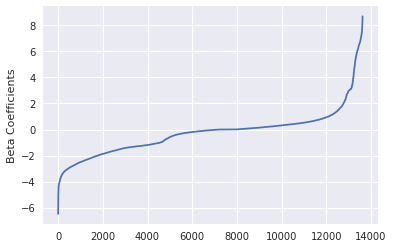

In [69]:
# coef
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
# 회귀 계수가 13625개, 값은 -6.5~8.7 사이에 분포

In [24]:
# print(len(beta))
# print(min(beta))
# print(max(beta))

13625
-6.486982679522038
8.705998096293454


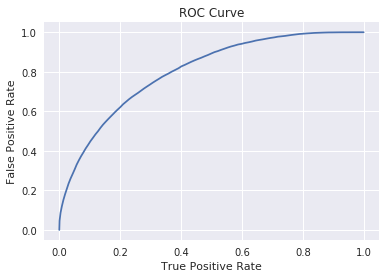

In [70]:
# ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

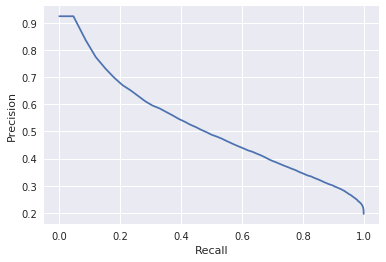

Training set areaUnderROC: 0.801262169733


In [71]:
# precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### logistic regression - validation

In [73]:
# preditction
lrPredictions = lrModel.transform(valid)
lrPredictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- is_train: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pu

In [32]:
# lrPredictions.select('display_id', 'ad_id', 'rawPrediction', 'prediction', 'probability').show(10)

+----------+------+--------------------+----------+--------------------+
|display_id| ad_id|       rawPrediction|prediction|         probability|
+----------+------+--------------------+----------+--------------------+
|      1775| 35998|[5.23780525173780...|       0.0|[0.99471616487600...|
|      2647| 36851|[5.57349752987941...|       0.0|[0.99621718756373...|
|      2923|  9147|[1.30623847779134...|       0.0|[0.78688303637737...|
|      5176| 56685|[4.10702816272170...|       0.0|[0.98380982704511...|
|      7838| 15936|[2.87891090066663...|       0.0|[0.94679402680588...|
|      2685| 15937|[3.05264816581340...|       0.0|[0.95489671779980...|
|      3636| 13363|[3.68314857822083...|       0.0|[0.97547301550894...|
|       410| 14546|[4.94762525707173...|       0.0|[0.99294980793434...|
|      7065|126860|[0.38342614505913...|       0.0|[0.59469918096868...|
|      7319|126860|[0.22249915571416...|       0.0|[0.55539643984005...|
+----------+------+--------------------+----------+

In [74]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Validation Area Under ROC', evaluator.evaluate(lrPredictions))

('Validation Area Under ROC', 0.7100529246454454)


In [75]:
# display_id, ad_id, probability를 셀렉해 logistic_final_df에 저장
logistic_final_df = lrPredictions.select('display_id', 'ad_id', 'probability')
# spark dataframe을 pandas dataframe으로 변환
logistic_final_pd = logistic_final_df.toPandas()

In [76]:
# probability는 [0일 확률, 1일 확률]로 되어 있다 -> 1일 확률만 뽑아 'clickprob' 열에 저장하자

# 일단 copy해서 'clickprob' 열 생성해놓자
logistic_final_pd['clickprob'] = logistic_final_pd.probability 

# for문 돌려서 1일 확률만 뽑아 'clickprob' 열에 저장하자
for i in range(len(logistic_final_pd)): # for문
    logistic_final_pd.clickprob[i] = logistic_final_pd.probability[i][1]

In [77]:
# clickprob 열이 잘 생성되었다
logistic_final_pd.head(5)

,display_id,ad_id,probability,clickprob
0,1775,35998,"[0.9947161648760094, 0.005283835123990557]",0.00528384
1,2647,36851,"[0.996217187563732, 0.003782812436267944]",0.00378281
2,2923,9147,"[0.7868830363773703, 0.21311696362262975]",0.213117
3,5176,56685,"[0.9838098270451137, 0.01619017295488634]",0.0161902
4,7838,15936,"[0.9467940268058844, 0.05320597319411551]",0.053206


In [84]:
# 'display_id', 'ad_id', 'clickprob'만 저장해야지
logistic_final_pd = logistic_final_pd[['display_id', 'ad_id', 'clickprob']]

# csv 파일로 bucket에 저장하자
from io import BytesIO
logistic_final_pd.to_csv('logistic_final_pd.csv', index=False)
!gsutil cp 'logistic_final_pd.csv' 'gs://capstone-03/output/logistic_final_pd.csv'

Copying file://logistic_final_pd.csv [Content-Type=text/csv]...
/ [1 files][787.9 KiB/787.9 KiB]                                                
Operation completed over 1 objects/787.9 KiB.                                    


## logistic regression 결과를 submission 해보려고 했으나 실패!

In [91]:
# clicks_test 불러오기
%gcs read --object gs://capstone-01/data/clicks_test.csv --variable test_file
clicks_test = pd.read_csv(BytesIO(test_file))

In [92]:
# clicks_test와 logistic_final_pd를 2개의 키('display_id', 'ad_id')로 merge
new_df = pd.merge(clicks_test, logistic_final_pd, how='left', left_on=['display_id', 'ad_id'], right_on=['display_id', 'ad_id'])

In [97]:
# merge한 데이터에서 NaN 있나 확인
nan_rows = new_df[new_df['clickprob'].isnull()]
print(nan_rows.shape)
print(clicks_test.shape)
# NaN의 비율 = 100% -> 실패!

(32225162, 3)
(32225162, 2)


## decision tree

In [98]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dtPredictions = dtModel.transform(valid)
dtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|      1775| 35998|       0.0|[0.79164539188154...|
|      2647| 36851|       0.0|[0.79164539188154...|
|      2923|  9147|       0.0|[0.79164539188154...|
|      5176| 56685|       0.0|[0.79164539188154...|
|      7838| 15936|       0.0|[0.79164539188154...|
|      2685| 15937|       0.0|[0.79164539188154...|
|      3636| 13363|       0.0|[0.79164539188154...|
|       410| 14546|       0.0|[0.79164539188154...|
|      7065|126860|       0.0|[0.79164539188154...|
|      7319|126860|       0.0|[0.79164539188154...|
+----------+------+----------+--------------------+
only showing top 10 rows



In [99]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(dtPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.539490273354


## random forest

In [100]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPredictions = rfModel.transform(valid)
%time rfPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|      1775| 35998|       0.0|[0.80342497028599...|
|      2647| 36851|       0.0|[0.80342497028599...|
|      2923|  9147|       0.0|[0.80527748469677...|
|      5176| 56685|       0.0|[0.80342497028599...|
|      7838| 15936|       0.0|[0.82046959481776...|
|      2685| 15937|       0.0|[0.82046959481776...|
|      3636| 13363|       0.0|[0.82302627209531...|
|       410| 14546|       0.0|[0.80527748469677...|
|      7065|126860|       0.0|[0.80342497028599...|
|      7319|126860|       0.0|[0.80342497028599...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.01 s


In [ ]:
predictions.select("prediction", "label", "features").show(5)

In [101]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(rfPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.632269354264


## gradient-boosted tree

In [102]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(valid)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|      1775| 35998|       0.0|[0.80395678992433...|
|      2647| 36851|       0.0|[0.80395678992433...|
|      2923|  9147|       0.0|[0.77506175842256...|
|      5176| 56685|       0.0|[0.80395678992433...|
|      7838| 15936|       0.0|[0.81917736982482...|
|      2685| 15937|       0.0|[0.81917736982482...|
|      3636| 13363|       0.0|[0.81917736982482...|
|       410| 14546|       0.0|[0.80395678992433...|
|      7065|126860|       0.0|[0.80395678992433...|
|      7319|126860|       0.0|[0.80395678992433...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.66 s


In [103]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.641810725197


In [ ]:
# 시간 체크 -> 안 돌아가!!
import datetime
start_time = time.time()

# tuning parameter : best param 찾는 과정 있음
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations. This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
cvPredictions = cvModel.transform(valid)
evaluator.evaluate(cvPredictions)

print("--- %s seconds ---" % (time.time() - start_time))